# Universal Inverse Problem Demo - Color images
## important: run this on GPU !!!!!!!!!!!

In [1]:
import numpy as np
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import matplotlib.pylab as plt
import os
import time
import torch
import sys
sys.path.insert(0, 'code')
from network import *
from Utils_inverse_prob import *
from algorithm_inv_prob import *
import argparse

%matplotlib inline

## load denoiser

In [2]:
parser = argparse.ArgumentParser(description='BF_CNN_color')
parser.add_argument('--dir_name', default= '../noise_range_')
parser.add_argument('--kernel_size', default= 3)
parser.add_argument('--padding', default= 1)
parser.add_argument('--num_kernels', default= 64)
parser.add_argument('--num_layers', default= 20)
parser.add_argument('--num_channels', default= 3)
args = parser.parse_args('')

model = Net(args)
if torch.cuda.is_available():
    model = model.cuda()


model_path = 'denoisers/BF_CNN_color/noise_range_0to100/model.pt'

if torch.cuda.is_available():
    learned_params =torch.load(model_path)

else:
    learned_params =torch.load(model_path, map_location='cpu' )


model.load_state_dict(learned_params)
model.eval();


/Users/zahra/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


## Synthesis

value range 0.19 1.0


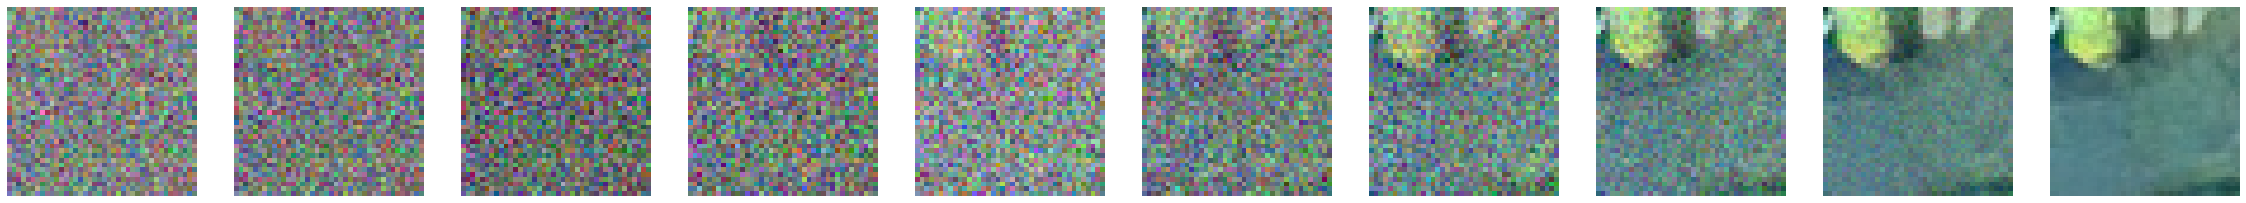

In [99]:
freq =5
synth = synthesis()        
        
sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c=synth.M_T(torch.zeros((3,40,40))), 
                                    M_T= synth.M_T,
                                    M = synth.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = freq,
                                    h0=.01, 
                                    beta = .5,          
                                    save_interm=True)

## plot the progression and the final sample

f, axs = plt.subplots(1,len(intermed_Ys), figsize = ( 4*len(intermed_Ys),4))
axs = axs.ravel()

for ax in range(len(intermed_Ys)): 
    fig = axs[ax].imshow(rescale_image(intermed_Ys[ax].permute(1,2,0).detach().numpy()))
    axs[ax].axis('off')
fig = axs[-1].imshow(rescale_image(sample.permute(1,2,0).detach().numpy()) )
axs[-1].axis('off')
print('value range', np.round(np.min(sample.permute(1,2,0).detach().numpy() ),2), np.round(np.max(sample.permute(1,2,0).detach().numpy() )))        



----------------------------- 10
sigma  0.9565748924026568
----------------------------- 20
sigma  0.8274455720781758
----------------------------- 30
sigma  0.6556684843535748
----------------------------- 40
sigma  0.4888566149110259
----------------------------- 50
sigma  0.3425938085547528
----------------------------- 60
sigma  0.2270707157941478
----------------------------- 70
sigma  0.12212432477088128
----------------------------- 80
sigma  0.060639202630234555
----------------------------- 90
sigma  0.022489542111696455
-------- total number of iterations,  96
-------- average time per iteration (s),  0.0575
value range 0.25 1.0


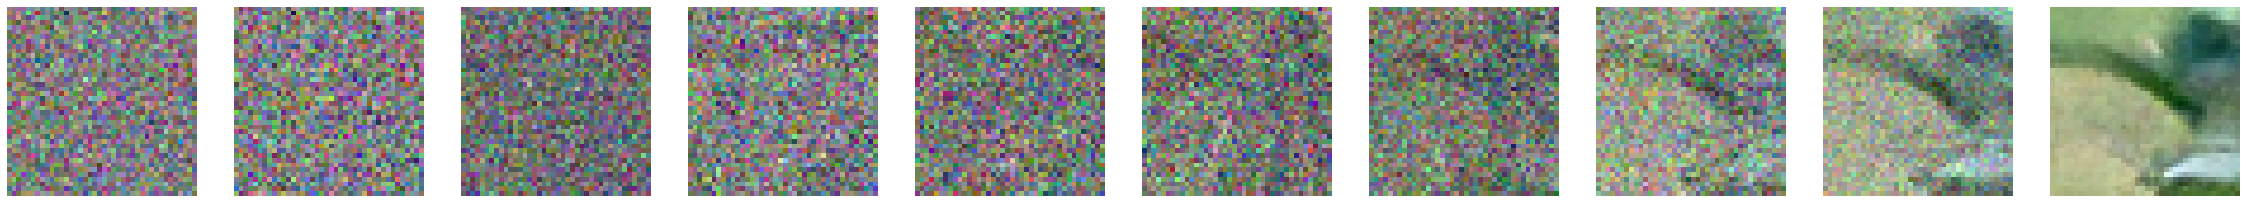

In [352]:
freq =10
synth = synthesis()        
        
sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c=synth.M_T(torch.zeros((40,40,3))), 
                                    M_T= synth.M_T,
                                    M = synth.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = freq,
                                    h0=.01, 
                                    beta = .1,          
                                    save_interm=True)


## plot the progression and the final sample

f, axs = plt.subplots(1,len(intermed_Ys), figsize = ( 4*len(intermed_Ys),4))
axs = axs.ravel()

for ax in range(len(intermed_Ys)): 
    fig = axs[ax].imshow(rescale_image(intermed_Ys[ax]) )
    axs[ax].axis('off')
fig = axs[-1].imshow(rescale_image(sample))
axs[-1].axis('off')
print('value range', np.round(np.min(sample),2), np.round(np.max(sample )))        



----------------------------- 10
sigma  tensor(0.9229)
----------------------------- 20
sigma  tensor(0.7728)
----------------------------- 30
sigma  tensor(0.5702)
----------------------------- 40
sigma  tensor(0.4032)
----------------------------- 50
sigma  tensor(0.2635)
----------------------------- 60
sigma  tensor(0.1607)
----------------------------- 70
sigma  tensor(0.0881)
----------------------------- 80
sigma  tensor(0.0467)
----------------------------- 90
sigma  tensor(0.0183)
-------- total number of iterations,  95
-------- average time per iteration (s),  0.0496
value range 0.14 1.0


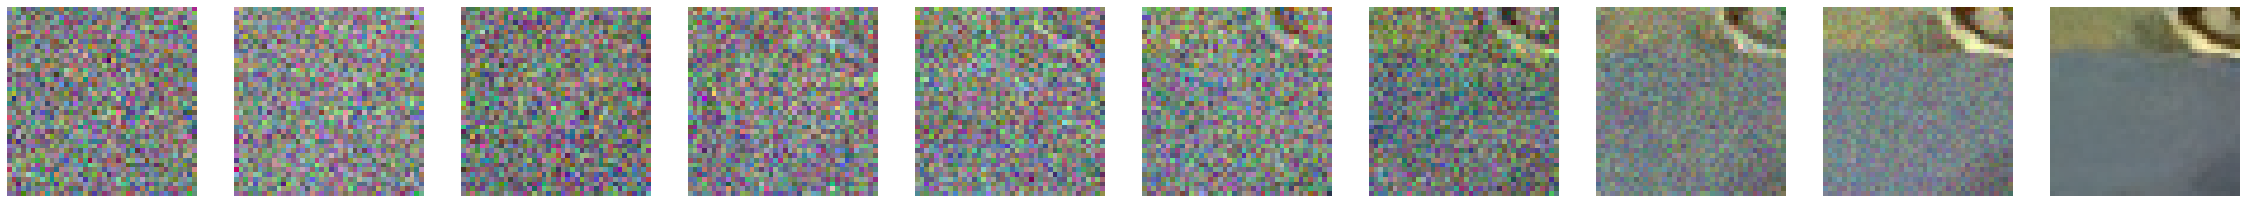

In [20]:
freq =10
synth = synthesis()        
        
sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c=synth.M_T(torch.zeros((3,40,40))), 
                                    M_T= synth.M_T,
                                    M = synth.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = freq,
                                    h0=.01, 
                                    beta = .1,          
                                    save_interm=True)


## plot the progression and the final sample

f, axs = plt.subplots(1,len(intermed_Ys), figsize = ( 4*len(intermed_Ys),4))
axs = axs.ravel()

for ax in range(len(intermed_Ys)): 
    fig = axs[ax].imshow(rescale_image(intermed_Ys[ax].permute(1,2,0).detach().numpy()) )
    axs[ax].axis('off')
fig = axs[-1].imshow(rescale_image(sample.permute(1,2,0).detach().numpy()) )
axs[-1].axis('off')
print('value range', np.round(np.min(sample.permute(1,2,0).detach().numpy() ),2), np.round(np.max(sample.permute(1,2,0).detach().numpy() )))        



----------------------------- 8
sigma  0.931009829044342
----------------------------- 16
sigma  0.7670453786849976
----------------------------- 24
sigma  0.5666341781616211
----------------------------- 32
sigma  0.3766624331474304
----------------------------- 40
sigma  0.2179497480392456
----------------------------- 48
sigma  0.09605829417705536
----------------------------- 56
sigma  0.03192809969186783
-------- total number of iterations,  63
-------- average time per iteration (s),  0.0494
value range 0 254


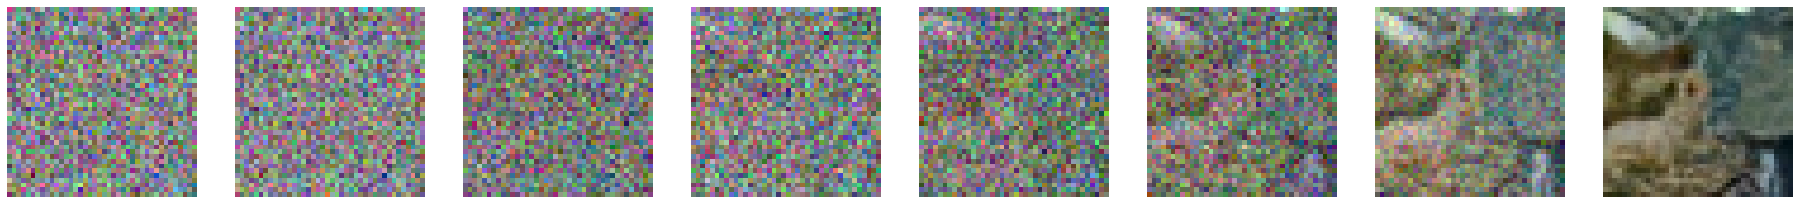

In [35]:
freq =8
synth = synthesis()        
        
sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c=synth.M_T(torch.zeros((3,40,40))), 
                                    M_T= synth.M_T,
                                    M = synth.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = freq,
                                    h0=.01, 
                                    beta = .2,          
                                    save_interm=True)

## plot the progression and the final sample


plot_synthesis(intermed_Ys, sample)

# Inverse probems

## load a test image

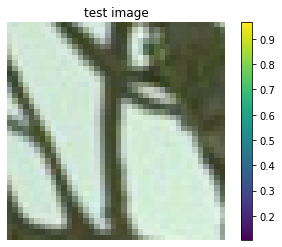

In [4]:
test_folder_path = 'test_images/color/test/'

x = single_image_loader(test_folder_path,9)
x = x[:,100:140,100:140] # crop a patch
if x.dtype == torch.uint8: 
    x = x/255
plt.imshow(x.permute(1,2,0))
plt.title('test image')
plt.colorbar()
plt.axis('off');

## 1. Inpainting 



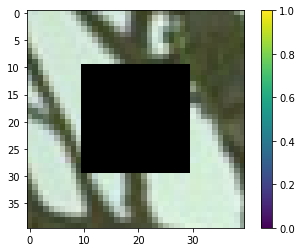

In [5]:
inpaint = inpainting(x.size(), 20,20)
plt.imshow(inpaint.M(inpaint.M_T(x)).permute(1,2,0), vmin=0, vmax = 1)
plt.colorbar()

----------------------------- 40
sigma  0.8685020804405212
----------------------------- 80
sigma  0.6282734870910645
----------------------------- 120
sigma  0.4103802442550659
----------------------------- 160
sigma  0.2608620524406433
----------------------------- 200
sigma  0.14047026634216309
----------------------------- 240
sigma  0.06768609583377838
----------------------------- 280
sigma  0.014353103004395962
-------- total number of iterations,  286
-------- average time per iteration (s),  0.051


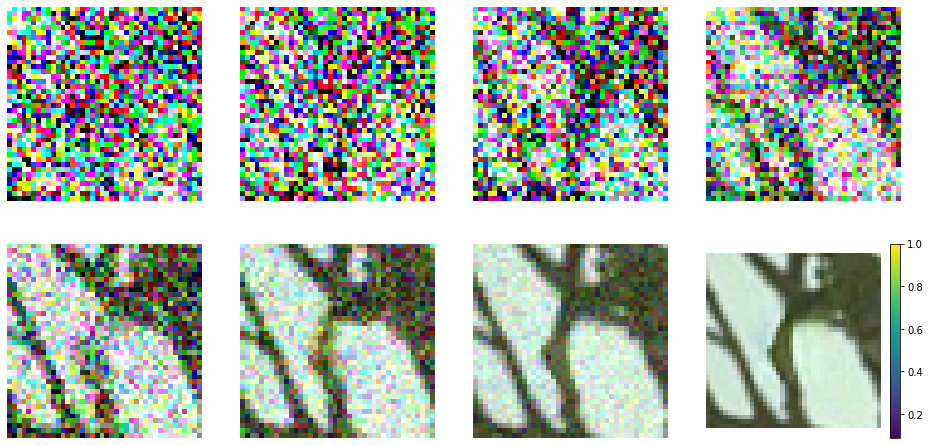

In [22]:
sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c= inpaint.M_T(x), 
                                    M_T= inpaint.M_T,
                                    M = inpaint.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = 40,
                                    h0=.01, 
                                    beta = .01,          
                                    save_interm=True)



plot_all_samples(sample, intermed_Ys)

## 2. random pixel drop

----------------------------- 20
sigma  0.9790085554122925
----------------------------- 40
sigma  0.9756061434745789
----------------------------- 60
sigma  0.8268670439720154
----------------------------- 80
sigma  0.6238470077514648
----------------------------- 100
sigma  0.46177124977111816
----------------------------- 120
sigma  0.3538322150707245
----------------------------- 140
sigma  0.25877732038497925
----------------------------- 160
sigma  0.1723969429731369
----------------------------- 180
sigma  0.10225670039653778
----------------------------- 200
sigma  0.05289403721690178
----------------------------- 220
sigma  0.013846593908965588
-------- total number of iterations,  224
-------- average time per iteration (s),  0.0486


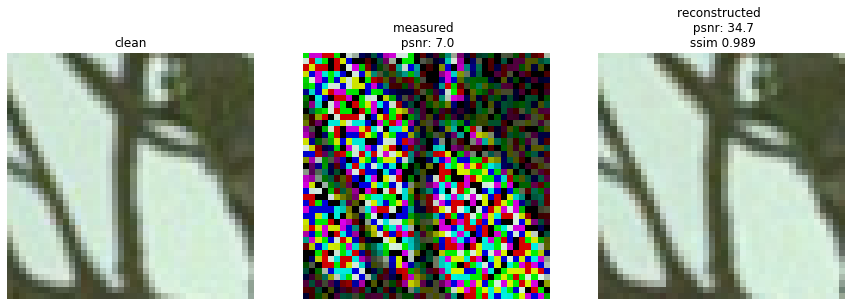

In [23]:
rand_pix = rand_pixels(x.size(), .5)

sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c= rand_pix.M_T(x), 
                                    M_T= rand_pix.M_T,
                                    M = rand_pix.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = 20,
                                    h0=.01, 
                                    beta = 0.01,          
                                    save_interm=False)
## plot
plot_sample(x, rand_pix.M(rand_pix.M_T(x)), sample)

## 3. super resolution 


----------------------------- 20
sigma  0.9968641996383667
----------------------------- 40
sigma  0.9267935752868652
----------------------------- 60
sigma  0.8199067115783691
----------------------------- 80
sigma  0.6417934894561768
----------------------------- 100
sigma  0.49126675724983215
----------------------------- 120
sigma  0.41193583607673645
----------------------------- 140
sigma  0.3144000172615051
----------------------------- 160
sigma  0.2254175990819931
----------------------------- 180
sigma  0.1386907547712326
----------------------------- 200
sigma  0.06951460242271423
----------------------------- 220
sigma  0.01588170975446701
-------- total number of iterations,  224
-------- average time per iteration (s),  0.0559


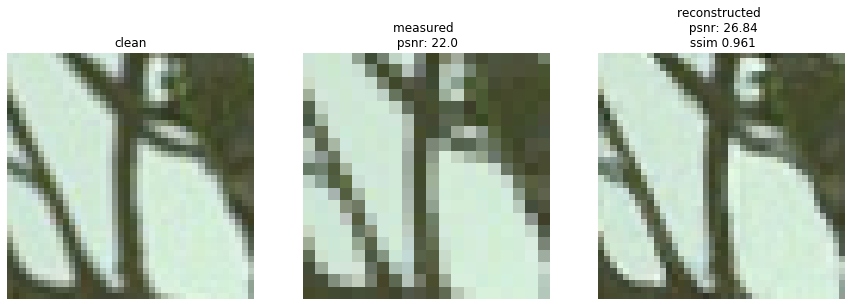

In [24]:

super_res = super_resolution(x.size(), 2)

sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c=super_res.M_T(x), 
                                    M_T= super_res.M_T,
                                    M = super_res.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = 20,
                                    h0=.01, 
                                    beta = 0.01,          
                                    save_interm=False)

plot_sample(x,super_res.M(super_res.M_T(x)), sample)

## 4. Random basis

----------------------------- 20
sigma  0.9494392275810242
----------------------------- 40
sigma  0.8520443439483643
----------------------------- 60
sigma  0.6930155754089355
----------------------------- 80
sigma  0.5539745092391968
----------------------------- 100
sigma  0.40296900272369385
----------------------------- 120
sigma  0.25136077404022217
----------------------------- 140
sigma  0.14213472604751587
----------------------------- 160
sigma  0.05164365470409393


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------- total number of iterations,  175
-------- average time per iteration (s),  0.0555


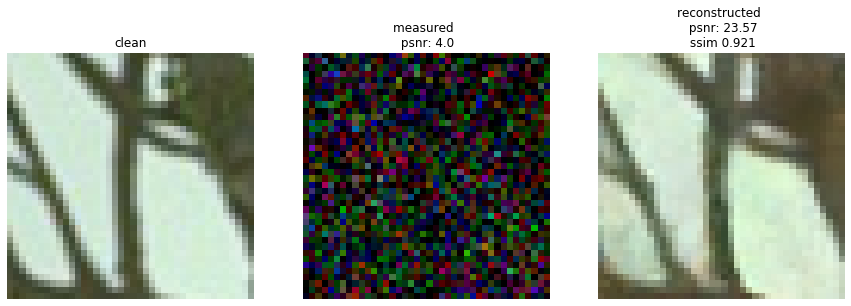

In [26]:
rand_basis = random_basis(x.shape , .1)

sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c= rand_basis.M_T(x), 
                                    M_T= rand_basis.M_T,
                                    M = rand_basis.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = 20,
                                    h0=.01, 
                                    beta = .01,          
                                    save_interm=False)
# plot
plot_sample(x, rand_basis.M(rand_basis.M_T(x)), sample)